# Hw1: 星星與銀河的分類（Star and galaxy）

1. 使用 RandomForestClassifier 的準確度（accuracy） (3%/15%) [需附上已經有跑出結果的程式碼]
2. 使用 SimpleNeuralNetwork 的準確度（accuracy） (3%/15%) [需附上已經有跑出結果的程式碼]
3. 請說明 RandomForestClassifier 的分類原理 (3%/15%)
4. 請說明 SimpleNeuralNetwork 的分類原理 (3%/15%)
5. 請選擇其中一種分類法，提升其準確度（accuracy）(2%/15%)，並說明你如何提升(1%/15%)

# Image Classification Pipeline

In [27]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define dataset directory
train_data_dir = "./Cutout Files"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


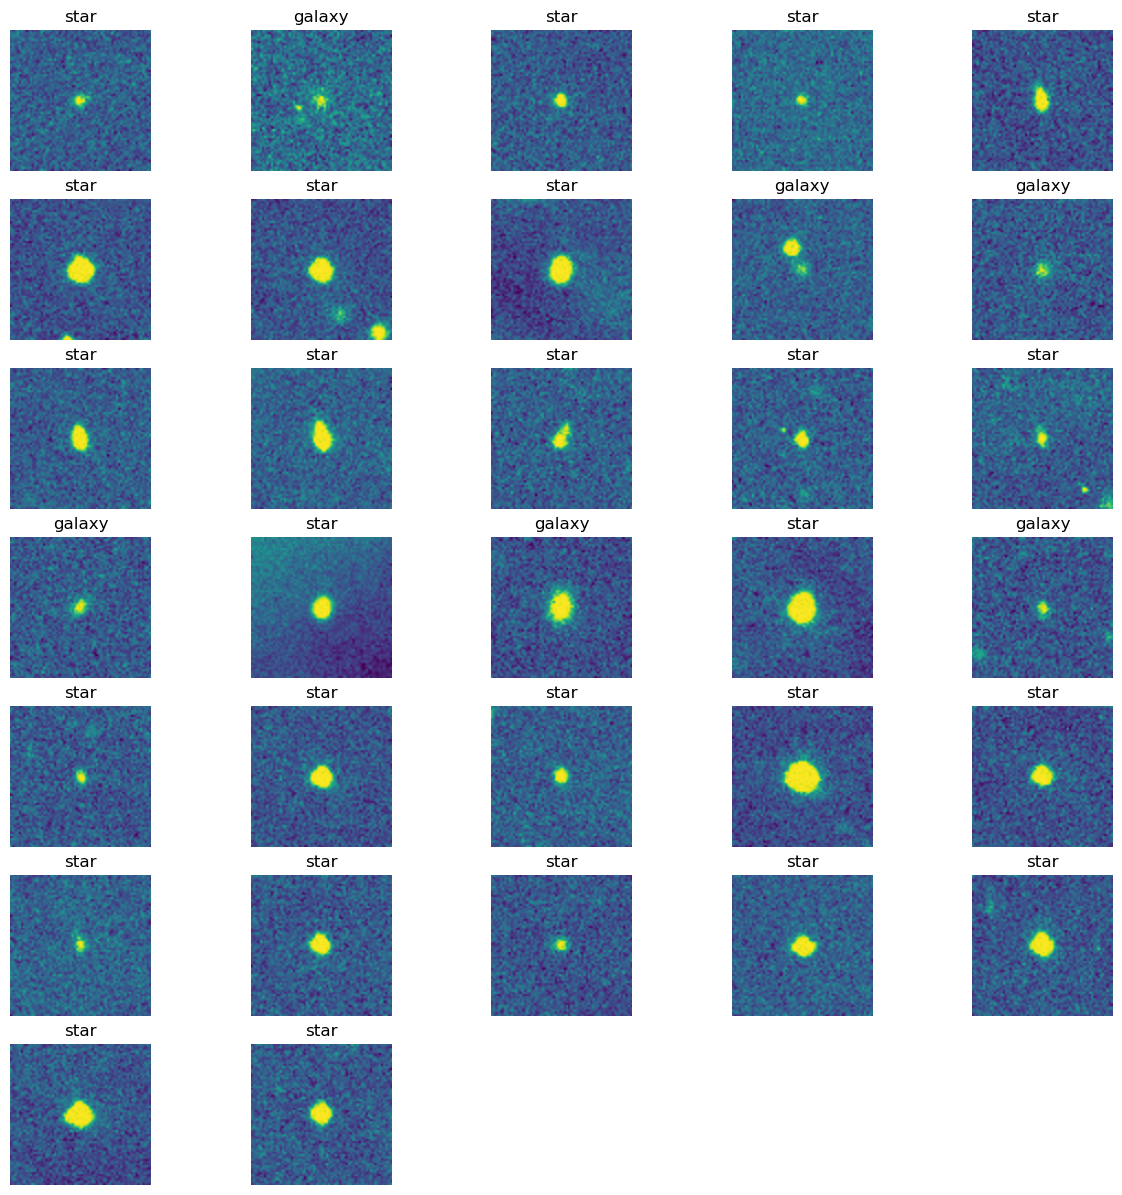

In [28]:
# Step 2: Visualize the Dataset
class_names = train_dataset.classes

def visualize_dataset(loader):
    # Get a batch of images and labels
    images, labels = next(iter(loader))
    
    # Create a grid of 32 images
    plt.figure(figsize=(15, 15))
    for i in range(32):
        plt.subplot(7, 5, i + 1)
        
        # 將 tensor 轉換為 numpy 並轉換為 uint8 以便繪圖
        img = images[i].squeeze(0).numpy()  # 去掉不必要的通道維度，因為是單通道
        img = (img * 255).astype(np.uint8)  # 將範圍 [0, 1] 轉換為 [0, 255]
        
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])  # 取得類別名稱
        plt.axis("off")

# Visualize the first 32 images in the dataset
visualize_dataset(train_loader)


In [29]:
# Step 3: Train a Random Forest Classifier

# Extract features and labels
X = []
y = []
for img, label in train_dataset:
    X.append(img.view(-1).numpy())  # Flatten image into a 1D vector
    y.append(label)

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test set and calculate accuracy
y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy*100:.2f}%")


Random Forest Classifier Accuracy: 79.70%


In [30]:
# Step 4: Train a Simple Neural Network

import torch.nn as nn
import torch.optim as optim

# Define Simple Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model parameters
input_size = 128 * 128  # Image size after flattening
hidden_size = 128
num_classes = len(train_dataset.classes)
num_epochs = 10
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the Simple Neural Network
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Flatten images
        images = images.view(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.2999
Epoch [2/10], Loss: 0.6710
Epoch [3/10], Loss: 0.5279
Epoch [4/10], Loss: 0.6026
Epoch [5/10], Loss: 0.5927
Epoch [6/10], Loss: 0.6790
Epoch [7/10], Loss: 0.4038
Epoch [8/10], Loss: 0.3506
Epoch [9/10], Loss: 0.4566
Epoch [10/10], Loss: 0.5592


In [31]:
# Step 5: Evaluate Neural Network Accuracy

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Evaluate the model accuracy on the training data
nn_accuracy = evaluate_accuracy(model, train_loader)
print(f"Neural Network Accuracy: {nn_accuracy*100:.2f}%")


Neural Network Accuracy: 76.67%
